In [1]:
import glob
import numpy as np
import scipy.io
from tqdm import tqdm
import h5py
import copy
import matplotlib.pyplot as plt

In [2]:
save_file_1 = '../dataset_for_ML/NG_multiple_case_time_structured_11022022.hdf5'
save_file_2 = '../dataset_for_ML/NG_multiple_CNN_restructured_11022022.hdf5'
save_file_3 = '../dataset_for_ML/NG_multiple_CNN_restructured_cleaned_11022022.hdf5'

In [3]:
# function to expand the input matrix based on expd_size
def expd(original_mat, expd_size):
    sz_diff = np.floor((expd_size-original_mat.shape[0])/2).astype(int)
    output = np.zeros([expd_size,expd_size])
    output[sz_diff:sz_diff+original_mat.shape[0], sz_diff:sz_diff+original_mat.shape[1]] = original_mat
    return output[::3,::3]

def loadMat(filePath, expd_size, matlab_var):
    tmp = scipy.io.loadmat(filePath)[matlab_var]
    try:
        tmp = tmp.todense()
    except:
        pass

    tmp = expd(tmp, expd_size)
    tmp = np.expand_dims(tmp,axis=0)
    tmp = np.expand_dims(tmp,axis=0)
    tmp = np.expand_dims(tmp,axis=4)
    return tmp

# get all cases folder name
cases = glob.glob('..\\..\\Matlab_simulation_data_all\\case[!1_]*')
cases.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

expd_size = 600 # target domain size
save_freq = 100
end_iter = 35000

dm_sz = int(expd_size/3)
numCases = int(len(cases))
hdf5_file = h5py.File(save_file_1, mode='w')
hdf5_file.create_dataset("phi", (numCases,345,dm_sz,dm_sz,3), np.float32, chunks=(1,1,dm_sz,dm_sz,1), compression="gzip")

for i in tqdm(range(len(cases)), desc=f'Running ...'):
    inputFolder = cases[i]
    case = inputFolder.replace('..\\..\\Matlab_simulation_data_all\\','')

    # load theta
    thetaPath = glob.glob(inputFolder+'/theta_'+str(end_iter)+'.mat')
    theta = loadMat(thetaPath[-1], expd_size, 'theta_plot')

    # defined input data folder and grab a list of data files
    phiPath = glob.glob(inputFolder+'\\phi*00.mat')
    phiPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    jj=0
    for l in range(len(phiPath)-2):
        j = l+1
        iter = int(phiPath[j].replace('..\\..\\Matlab_simulation_data_all\\'+case+'\\phi_','').replace('.mat',''))
        if (iter >= 500 and (iter%save_freq)==0 and iter <= end_iter):
            # load data
            phi_dwn = loadMat(phiPath[j], expd_size, 'phi_plot')
            if np.max(phi_dwn)==0:
                print(f'!!{phiPath[j]}')
            iter_map = np.ones(phi_dwn.shape)*iter/35000
            iter_vars = np.concatenate([phi_dwn,theta,iter_map], axis=4)

            hdf5_file["phi"][i,jj,...] = iter_vars
                
            jj+=1

hdf5_file.close()

Running ...: 100%|██████████| 64/64 [05:34<00:00,  5.22s/it]


(64, 345, 200, 200, 3)


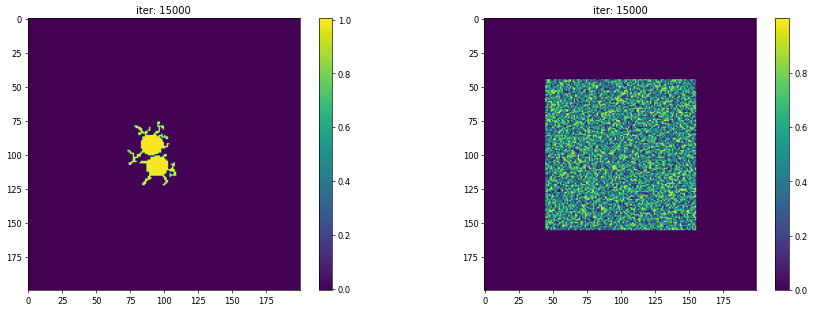

In [4]:
h5 = h5py.File(save_file_1, mode='r')
dataset = h5.get('phi')
print(dataset.shape)

id = np.random.randint(dataset.shape[0])
idx = np.random.randint(dataset.shape[1])
plt.figure(figsize=(18, 6), dpi=60)
plt.subplot(1,2,1)
plt.imshow(dataset[id,idx,:,:,0])
plt.title(f'iter: {int(dataset[id,idx,0,0,2]*35000)}')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(dataset[id,idx,:,:,1])
plt.title(f'iter: {int(dataset[id,idx,0,0,2]*35000)}')
plt.colorbar()
plt.show()

In [5]:
sz = dataset.shape[0]*(dataset.shape[1])

hdf5_file = h5py.File(save_file_2, mode='w')
hdf5_file.create_dataset("input", (sz, 3, dataset.shape[2],dataset.shape[3]), np.float32, chunks=(1, 3, dataset.shape[2],dataset.shape[3]), compression="gzip")
hdf5_file.create_dataset("output", (sz, 1, dataset.shape[2],dataset.shape[3]), np.float32, chunks=(1, 1, dataset.shape[2],dataset.shape[3]), compression="gzip")

k = 0
for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
    for j in range(dataset.shape[1]):
        hdf5_file["input"][k,0,:,:] = dataset[i,0,:,:,0]
        hdf5_file["input"][k,1,:,:] = dataset[i,0,:,:,1]
        hdf5_file["input"][k,2,:,:] = dataset[i,j,:,:,2]
        hdf5_file["output"][k,0,:,:] = dataset[i,j,:,:,0]
        k+=1  
hdf5_file.close()

Running ...: 100%|██████████| 64/64 [06:13<00:00,  5.83s/it]


In [6]:
h5 = h5py.File(save_file_2, mode='r')
input = h5.get('input')
output = h5.get('output')
print(input.shape)
print(output.shape)

ind_del = []
ind_keep = []
for i in range(output.shape[0]):
    if np.max(output[i,0,:,:])==0:
        ind_del.append(i)
    else:
        ind_keep.append(i)

print(f'ind_del: {len(ind_del)} | ind_keep: {len(ind_keep)}')

input_keep = np.delete(input,np.array(ind_del),axis=0)
output_keep = np.delete(output,np.array(ind_del),axis=0)
print(f'input {input_keep.shape} | output {output_keep.shape}')

hdf5_file = h5py.File(save_file_3, mode='w')
hdf5_file.create_dataset("input", input_keep.shape, np.float32, chunks=(1, 3, input_keep.shape[2],input_keep.shape[3]), compression="gzip")
hdf5_file.create_dataset("output", output_keep.shape, np.float32, chunks=(1, 1, output_keep.shape[2],output_keep.shape[3]), compression="gzip")

for i in tqdm(range(len(ind_keep)), desc="Running ..."):
    hdf5_file["input"][i,...] = np.expand_dims(input[ind_keep[i],...],axis=0)
    hdf5_file["output"][i,...] = np.expand_dims(output[ind_keep[i],...],axis=0)
    
h5.close()
hdf5_file.close()

(22080, 3, 200, 200)
(22080, 1, 200, 200)
ind_del: 548 | ind_keep: 21532
input (21532, 3, 200, 200) | output (21532, 1, 200, 200)


Running ...: 100%|██████████| 21532/21532 [02:20<00:00, 152.88it/s]


(21532, 3, 200, 200)


Checking ...: 100%|██████████| 21532/21532 [00:16<00:00, 1325.77it/s]


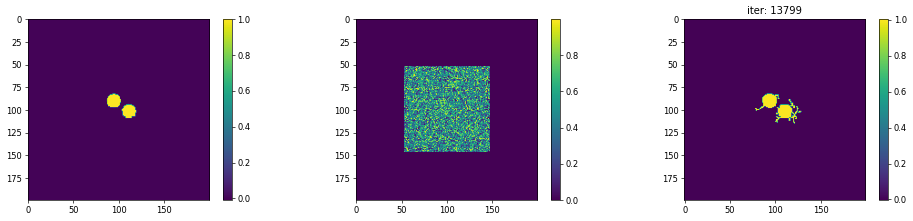

In [7]:
import h5py
from tqdm import tqdm
import numpy as np

h5 = h5py.File(save_file_3, mode='r')
x_train = h5.get('input')
y_train = h5.get('output')
print(x_train.shape)

for i in tqdm(range(x_train.shape[0]), desc="Checking ..." ):
    if np.max(x_train[i,0,:,:])==0:
        raise Exception(f'!! Not clean !! ind: {i} !!')

id = np.random.randint(x_train.shape[0])
plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(x_train[id,0,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(x_train[id,1,:,:])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(y_train[id,0,:,:])
plt.title(f'iter: {int(x_train[id,2,0,0]*35000)}')
plt.colorbar()
plt.show()

(21532, 3, 200, 200)


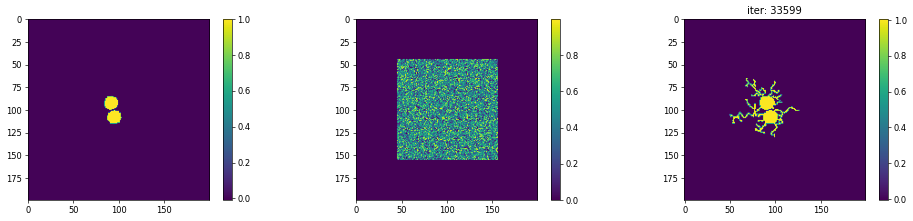

In [8]:
import h5py
from tqdm import tqdm
import numpy as np

h5 = h5py.File(save_file_3, mode='r')
x_train = h5.get('input')
y_train = h5.get('output')
print(x_train.shape)

id = np.random.randint(x_train.shape[0])
plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,3,1)
plt.imshow(x_train[id,0,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(x_train[id,1,:,:])
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(y_train[id,0,:,:])
plt.title(f'iter: {int(x_train[id,2,0,0]*35000)}')
plt.colorbar()
plt.show()